In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, RANSACRegressor

from scipy import stats

import joblib

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import matplotlib.dates as mdates

from netCDF4 import Dataset, num2date, date2num
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
ds = xr.open_dataset('../testMatchups/QuikSCAT_waveAndGlorysAdded_randomForestClassification.nc')
df = ds.to_dataframe()
ds

<xarray.Dataset> Size: 240MB
Dimensions:                                   (count: 264416)
Coordinates:
    LATITUDE                                  (count) float64 2MB -8.0 ... 9.0
    LONGITUDE                                 (count) float64 2MB 265.0 ... 2...
  * count                                     (count) int64 2MB 0 1 ... 295512
Data variables: (12/121)
    WDIR (TAO)                                (count) float32 1MB 140.6 ... 1...
    WDIR_QC                                   (count) float32 1MB 2.0 ... 2.0
    WDIR_DM                                   (count) |S1 264kB b'D' ... b'D'
    WSPD (TAO)                                (count) float32 1MB 6.79 ... 4.23
    WSPD_QC                                   (count) float32 1MB 2.0 ... 2.0
    WSPD_DM                                   (count) |S1 264kB b'D' ... b'D'
    ...                                        ...
    cos(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 2MB 0.9998 ... ...
    sin(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 2MB 0.02094 ......
    UWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 2MB -0.07678 .....
    VWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 2MB -0.1377 ......
    predicted_label                           (count) int64 2MB 1 1 1 ... 0 0 0
    DBSCAN_label                              (count) int64 2MB 1 1 1 ... 1 0 0

In [3]:
def robust_regression_ransac(x, y):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)

    #ransac = RANSACRegressor(random_state=42)
    #ransac.fit(x, y)

    model = RANSACRegressor(LinearRegression(), random_state=42)
    model.fit(x, y)

    Y = model.predict(x)
    meanOffset = np.mean(Y)
    

    slope = model.estimator_.coef_[0]
    intercept = model.estimator_.intercept_
    #r2 = model.score(x, y)  # R² on inliers

    return slope[0], intercept, meanOffset, Y  #,r2, model.inlier_mask_
    
def plotQS(thisDF, axes): # topTitle, labels):
    WSPD_DIFF = np.array(thisDF['WSPD_DIFF (QuikSCAT - TAO)'])
    WDIR_DIFF = np.array(thisDF['WDIR_DIFF (QuikSCAT - TAO)'])

    mask = np.logical_or(np.isnan(WSPD_DIFF), np.isnan(WDIR_DIFF))
    thisDF = thisDF.loc[~mask]

    deployments = thisDF['Deployment index']
    dep_labels = np.sort(np.unique(np.array(deployments)))
    startDates = []
    endDates = []

    for i in range(len(dep_labels)):
        dep = dep_labels[i]

        #print(startDates[i], endDates[i])
        #colorR =list(np.random.choice(range(256), size=3)/256)
        cmap = plt.get_cmap('Dark2')
        chosenColor = np.array(cmap(i % cmap.N))
        chosenColor[0:3] = chosenColor[0:3] * 0.7 #darkening
        colorR = tuple(chosenColor)
        
        ssubDF = thisDF.loc[thisDF['Deployment index'] == dep]
        minTime = np.min(ssubDF['QS_TIME'])
        maxTime = np.max(ssubDF['QS_TIME'])

        #print(dep, minTime, maxTime)
        
        startDates.append(minTime)
        endDates.append(maxTime)
        
        x = ((np.array(ssubDF['QS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'D')).reshape(-1,1)    
        y = np.array(ssubDF['WSPD_DIFF (QuikSCAT - TAO)']).reshape(-1,1)
        mask = ssubDF['predicted_label'].to_numpy() == 0
        badx = x[mask]
        bady = y[mask]
        x=x[~mask]
        y=y[~mask]

        timeArr = np.array(ssubDF['QS_TIME'])
        goodTime = timeArr[~mask]
        badTime = timeArr[mask]

        if len(x) <2:
            continue
    
        
        slopeSpd, interceptSpd, offsetYspd, Y = robust_regression_ransac(x, y)
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[0].plot(goodTime, Y, color=colorR)
        axes[0].scatter(goodTime, y, 
                        color = 'red', s = 0.2, label = 'predicted good')
        axes[0].scatter(badTime, bady, 
                        color = 'blue', s = 0.2, label = 'predicted bad')

        # axes[0].text(0.5, 1, topTitle, 
        #              color = 'k', fontweight='bold', fontsize = 15,
        #              ha = 'center', va = 'bottom', 
        #              transform=axes[0].transAxes)

        # axes[0].text(0.01, 0.95, labels[0], 
        #              color = 'k', fontweight='bold', fontsize = 12,
        #              ha = 'left', va = 'top', 
        #              transform=axes[0].transAxes)

        
        y = np.array(ssubDF['WDIR_DIFF (QuikSCAT - TAO)']).reshape(-1,1)
        bady = y[mask]
        y=y[~mask]
        
        slopeDir, interceptDir, offsetYdir, Y = robust_regression_ransac(x, y)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].plot(goodTime, Y, color=colorR)
        axes[1].scatter(goodTime, y, 
                        color = 'red', s = 0.2, label = 'predicted good')
        axes[1].scatter(badTime, bady, 
                        color = 'blue', s = 0.2, label = 'predicted bad')

        # axes[1].text(0.01, 0.95, labels[1], 
        #              color = 'k', fontweight='bold', fontsize = 12,
        #              ha = 'left', va = 'top', 
        #              transform=axes[1].transAxes)

        if x[-1] - x[0] > 60:
            xpos = np.mean(ssubDF['QS_TIME'])
            axes[0].text(xpos, 7, f'{slopeSpd*7:5.2f}', color = colorR, ha = 'center', va = 'top')
            axes[1].text(xpos, 170, f'{slopeDir*7:5.2f}', color = colorR, ha = 'center', va = 'top')

    
    #axes[0].set_title('Difference in wind speed (QS - TAO)')
    #axes[1].set_title('Difference in wind direction (QS - TAO)')

    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))   # remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='lower right')

    axes[0].set_ylabel('m/s')
    axes[1].set_ylabel('degrees')

    axes[0].set_ylim([-8, 8])
    axes[1].set_ylim([-180, 180])
    
    axes[0].xaxis.set_major_locator(mdates.YearLocator())
    axes[0].xaxis.set_minor_locator(mdates.MonthLocator())
    axes[0].grid(which = 'major', axis = 'both', lw = 1)
    axes[0].grid(which = 'minor', axis = 'both', lw = 0.2, alpha = 0.5)

    axes[1].xaxis.set_major_locator(mdates.YearLocator())
    axes[1].xaxis.set_minor_locator(mdates.MonthLocator())
    axes[1].grid(which = 'major', axis = 'both', lw = 1)
    axes[1].grid(which = 'minor', axis = 'both', lw = 0.2, alpha = 0.5)

In [4]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

In [5]:
ds

<xarray.Dataset> Size: 240MB
Dimensions:                                   (count: 264416)
Coordinates:
    LATITUDE                                  (count) float64 2MB -8.0 ... 9.0
    LONGITUDE                                 (count) float64 2MB 265.0 ... 2...
  * count                                     (count) int64 2MB 0 1 ... 295512
Data variables: (12/121)
    WDIR (TAO)                                (count) float32 1MB 140.6 ... 1...
    WDIR_QC                                   (count) float32 1MB 2.0 ... 2.0
    WDIR_DM                                   (count) |S1 264kB b'D' ... b'D'
    WSPD (TAO)                                (count) float32 1MB 6.79 ... 4.23
    WSPD_QC                                   (count) float32 1MB 2.0 ... 2.0
    WSPD_DM                                   (count) |S1 264kB b'D' ... b'D'
    ...                                        ...
    cos(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 2MB 0.9998 ... ...
    sin(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 2MB 0.02094 ......
    UWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 2MB -0.07678 .....
    VWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 2MB -0.1377 ......
    predicted_label                           (count) int64 2MB 1 1 1 ... 0 0 0
    DBSCAN_label                              (count) int64 2MB 1 1 1 ... 1 0 0

In [6]:
SUBDF = df.copy()
SUBDS = ds.copy()
for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]

    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == (lon + 360) % 360]
    subDS = SUBDS.where(SUBDS['LATITUDE'] == lat, drop=True)
    subDS = subDS.where(SUBDS['LONGITUDE'] == (lon + 360) % 360, drop=True)
    
    if len(subDF['QS_TIME']) <1:
        print(len(subDF['QS_TIME']))
        continue
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex = True, figsize=(20,8))

    plotQS(subDF, axes)

    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    
    
    title = f'siteWiseLinearRegressionImages/QuikSCAT/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_QuikSCAT.png'
    plt.suptitle(f'{lat:2d}'+ r'$\degree$' + f'{latUnits} {lon:3d}'+r'$\degree$' + f'{lonUnits}')
    plt.tight_layout()
    plt.savefig(title, dpi = 100)
    plt.close()

    subDS.to_netcdf(f'QuikSCAT_siteWisedata/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_QuikSCAT_matchups.nc')
    #subDF.close()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


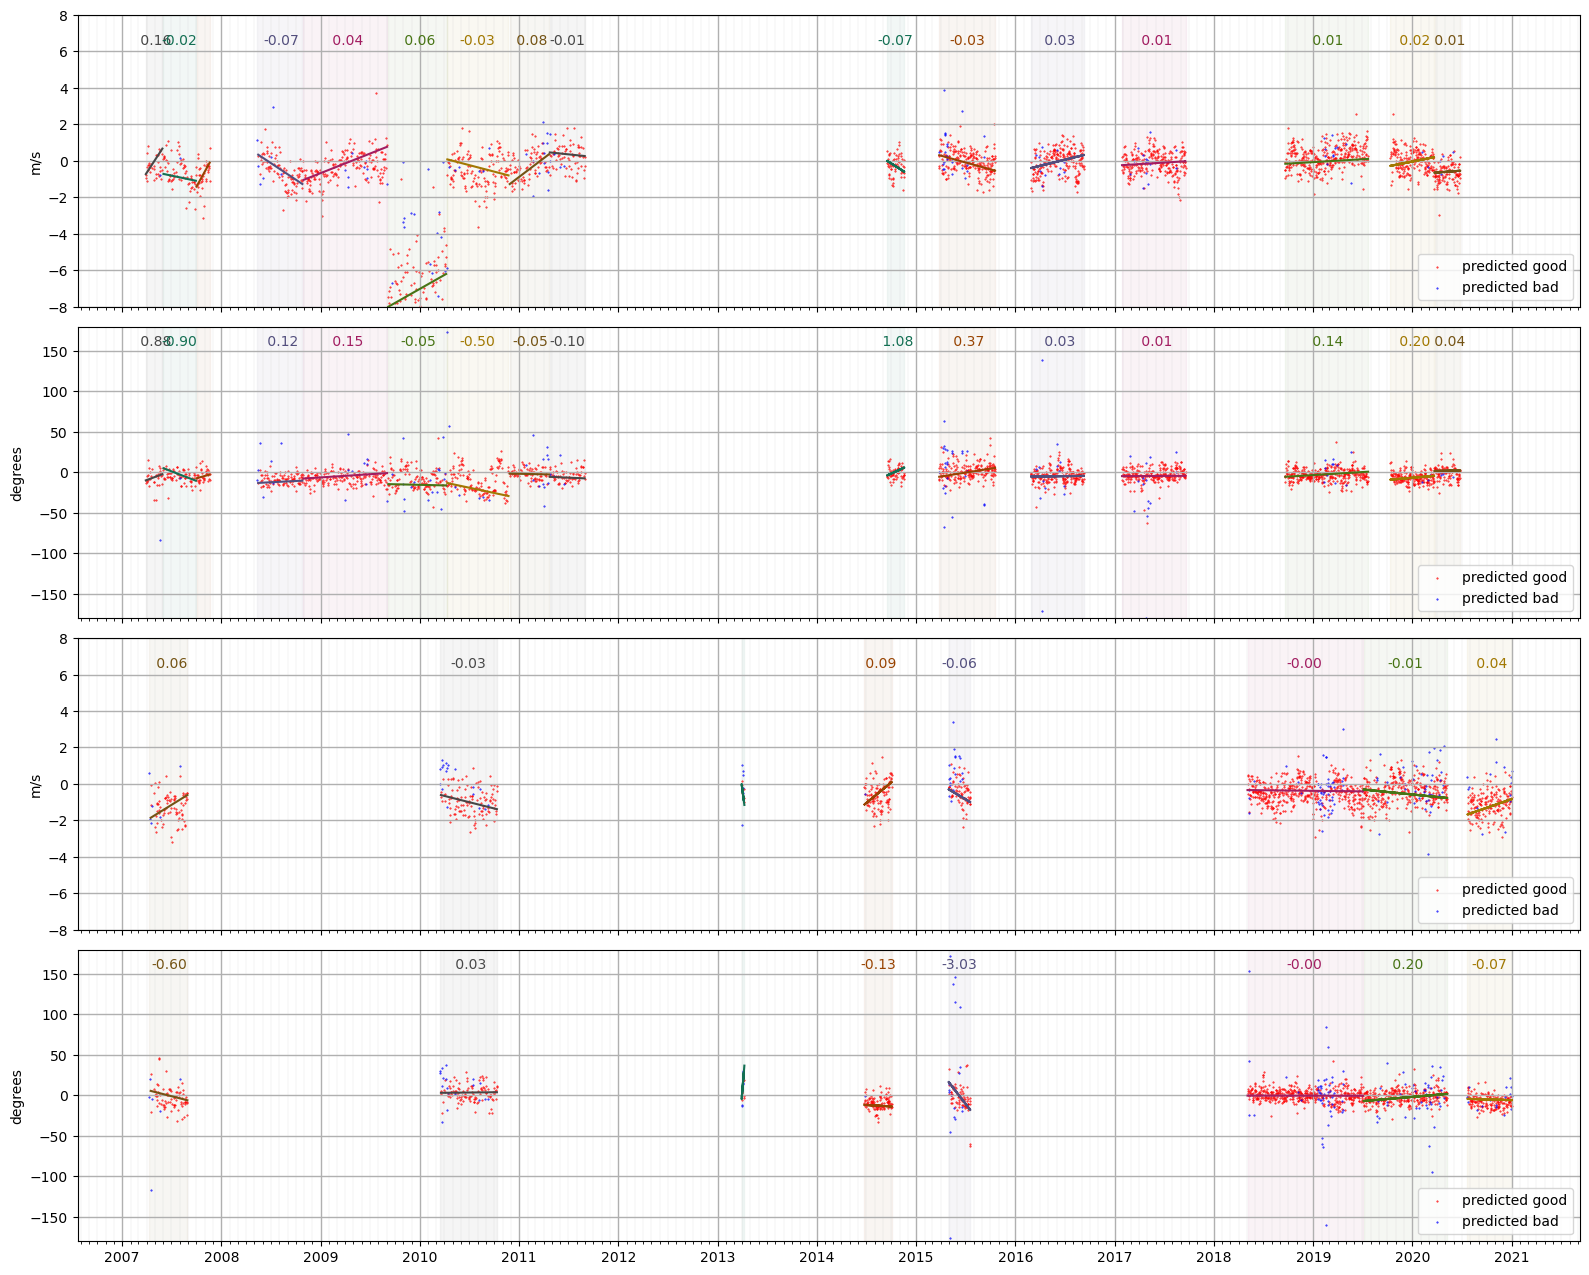

In [6]:
fac = 0.8
fig, axes = plt.subplots(nrows=4, ncols=1, sharex = True, figsize=(20*fac,16*fac))

SUBDF = df.copy()
lat = 0
lon = -140

subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
subDF = subDF.loc[subDF['LONGITUDE'] == (lon + 360) % 360]

if lat < 0:
    latUnits = 'S'
    lat = abs(lat)
else:
    latUnits = 'N'

if lon < 0:
    lonUnits = 'W'
    lon = abs(lon) # 360
else:
    lonUnits = 'E'
topTitle = f'{lat:2d}'+ r'$\degree$' + f'{latUnits} {lon:3d}'+r'$\degree$' + f'{lonUnits}'
plotQS(subDF, axes[0:2]) #, topTitle, ['A.', 'B.'])


SUBDF = df.copy()
lat = 2
lon = -110

subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
subDF = subDF.loc[subDF['LONGITUDE'] == (lon + 360) % 360]

if lat < 0:
    latUnits = 'S'
    lat = abs(lat)
else:
    latUnits = 'N'

if lon < 0:
    lonUnits = 'W'
    lon = abs(lon) # 360
else:
    lonUnits = 'E'
topTitle = f'{lat:2d}'+ r'$\degree$' + f'{latUnits} {lon:3d}'+r'$\degree$' + f'{lonUnits}'
plotQS(subDF, axes[2:4])#, topTitle, ['C.', 'D.'])

plt.tight_layout()
#plt.savefig('timeSeriesPlot.png', dpi = 100)